#
#
# FGSM Attack and Impacted Features #
#
#

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import numpy as np
import pandas as pd

In [2]:
import tensorflow as tf
from tensorflow.python.platform import flags
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from keras.optimizers import RMSprop , adam
from keras import backend

Using TensorFlow backend.


In [3]:
from sklearn import metrics
from sklearn.metrics import accuracy_score , roc_curve , auc , f1_score, classification_report
from sklearn.preprocessing import LabelEncoder , MinMaxScaler

In [4]:
"""# IBM Art Attack 
from __future__ import absolute_import, division, print_function, unicode_literals

import sys
from os.path import abspath

from art.attacks.fast_gradient import FastGradientMethod
from art.classifiers import KerasClassifier
from art.utils import load_dataset"""

'# IBM Art Attack \nfrom __future__ import absolute_import, division, print_function, unicode_literals\n\nimport sys\nfrom os.path import abspath\n\nfrom art.attacks.fast_gradient import FastGradientMethod\nfrom art.classifiers import KerasClassifier\nfrom art.utils import load_dataset'

In [5]:
###################### CleverHans Libraries ##########################

from cleverhans.attacks import FastGradientMethod, SPSA, SaliencyMapMethod
from cleverhans.utils_tf import model_train , model_eval, batch_eval
from cleverhans.attacks_tf import jacobian_graph
from cleverhans.utils import other_classes
from cleverhans.utils_keras import KerasModelWrapper
from cleverhans.utils import other_classes, set_log_level
from keras import backend

###  Data Preprocessing 

In [6]:
df = pd.read_csv('New.csv')
print("Initial data shape:", df.shape)

Initial data shape: (4464, 28)


In [7]:
df.head()

,DL Latency (ms),UL Interference,UL PRB Usage Rate(%),L.DLPwr.Avg(dBm),L.UL.RSRP.PUSCH,L.UL.RSSI.PUCCH,L.E-RAB.AbnormRel.Cong,L.E-RAB.AbnormRel.eNBTot.UEAbnormal,L.E-RAB.AbnormRel.HOFailure,L.E-RAB.AbnormRel.QCI.6,...,L.Paging.S1.Rx,L.Paging.S1.Rx.CS,L.Paging.UU.Att,L.Paging.UU.Num,L.Paging.UU.SIUpdate,L.Paging.UU.Succ,L.Paging.UU.Succ.CSFB,Average Active User,L.UECNTX.AbnormRel,Label
0,40.1989,-116,8.1984,41.8,17060,336,0,0,0,0,...,18133,236,18137,17908,0,296,3,7.5092,0,Normal
1,12.909,-117,6.8713,41.7,12222,299,0,0,0,0,...,18133,236,18137,17908,0,209,4,5.9339,0,Normal
2,30.8297,-118,7.6623,41.7,48923,204,0,0,0,0,...,18132,236,18137,17908,0,273,0,11.8878,0,Normal
3,26.4364,-119,9.0134,42.1,34488,37,0,0,0,0,...,10602,62,10605,10521,0,199,1,11.1336,0,Normal
4,32.0612,-108,9.0785,42,27300,99255,0,0,0,0,...,10602,62,10605,10521,0,201,1,8.6617,0,Normal


In [8]:
df.describe()

,L.UL.RSRP.PUSCH,L.UL.RSSI.PUCCH,L.E-RAB.AbnormRel.Cong,L.E-RAB.AbnormRel.eNBTot.UEAbnormal,L.E-RAB.AbnormRel.HOFailure,L.E-RAB.AbnormRel.QCI.6,L.E-RAB.AbnormRel.QCI.9,L.E-RAB.AbnormRel.Radio.DRBReset,L.E-RAB.AbnormRel.Radio.SRBReset,L.E-RAB.AbnormRel.Radio.ULSyncFail,...,L.Paging.Dis.PchCong,L.Paging.S1.Rx,L.Paging.S1.Rx.CS,L.Paging.UU.Att,L.Paging.UU.Num,L.Paging.UU.SIUpdate,L.Paging.UU.Succ,L.Paging.UU.Succ.CSFB,Average Active User,L.UECNTX.AbnormRel
count,4464.000000,4464.000000,4464.0,4464.0,4464.000000,4464.000000,4464.000000,4464.000000,4464.000000,4464.0,...,4464.0,4464.000000,4464.000000,4464.000000,4464.000000,4464.000000,4464.000000,4464.000000,4464.000000,4464.000000
mean,39493.069668,15227.179659,0.0,0.0,0.016129,0.097670,4.742384,0.982079,0.047715,0.0,...,0.0,30395.443772,874.225582,30374.159722,29700.103047,161.928763,359.864247,12.171819,9.449456,31.073029
std,43974.069477,37906.084437,0.0,0.0,0.132910,0.611602,14.405103,1.517289,0.231333,0.0,...,0.0,16519.784476,686.044496,16539.652852,15799.618047,1616.185765,276.467322,13.890865,7.252578,110.709336
min,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,5284.250000,119.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.0,13738.000000,162.000000,13593.000000,13747.000000,0.000000,115.000000,1.000000,3.339425,0.000000
50%,26174.500000,390.000000,0.0,0.0,0.000000,0.000000,1.000000,0.000000,0.000000,0.0,...,0.0,34419.000000,916.500000,34411.000000,33682.000000,0.000000,320.500000,7.000000,8.154750,1.000000
75%,58275.250000,1237.000000,0.0,0.0,0.000000,0.000000,3.000000,1.000000,0.000000,0.0,...,0.0,44555.500000,1456.000000,44559.750000,43182.500000,0.000000,554.000000,20.000000,14.000600,3.000000
max,312019.000000,212317.000000,0.0,0.0,2.000000,15.000000,156.000000,15.000000,3.000000,0.0,...,0.0,63144.000000,2453.000000,63128.000000,60450.000000,26112.000000,1288.000000,86.000000,42.575000,998.000000


In [9]:
# Remove Cols with Zeros
df2 = df.loc[:, (df != 0).any(axis=0)] 

In [10]:
#df2 = df2.drop(['L.Traffic.ActiveUser.DL.QCI.1.Max', 'L.Traffic.ActiveUser.UL.QCI.1.Max', 'E-RAB Drop Rate (%)_ENPMLTE','L.E-RAB.AbnormRel','L.E-RAB.AbnormRel.eNBTot','L.E-RAB.AbnormRel.TNL.Other'], axis=1)

In [11]:
df2 = df2.replace('/0', np.nan)
#df2 = df2.replace('NIL', np.nan)

In [12]:
df2.isnull().any().any(), df2.shape

(True, (4464, 23))

In [13]:
df2 = df2.dropna() # removing rows with missing vlaues 

In [14]:
df2.shape

(4379, 23)

In [15]:
df2.dtypes

DL Latency (ms)                       object
UL Interference                       object
UL PRB Usage Rate(%)                  object
L.DLPwr.Avg(dBm)                      object
L.UL.RSRP.PUSCH                        int64
L.UL.RSSI.PUCCH                        int64
L.E-RAB.AbnormRel.HOFailure            int64
L.E-RAB.AbnormRel.QCI.6                int64
L.E-RAB.AbnormRel.QCI.9                int64
L.E-RAB.AbnormRel.Radio.DRBReset       int64
L.E-RAB.AbnormRel.Radio.SRBReset       int64
L.E-RAB.AbnormRel.Radio.UuNoReply      int64
L.E-RAB.AbnormRel.TNL                  int64
L.Paging.S1.Rx                         int64
L.Paging.S1.Rx.CS                      int64
L.Paging.UU.Att                        int64
L.Paging.UU.Num                        int64
L.Paging.UU.SIUpdate                   int64
L.Paging.UU.Succ                       int64
L.Paging.UU.Succ.CSFB                  int64
Average Active User                  float64
L.UECNTX.AbnormRel                     int64
Label     

In [16]:
df2 = df2.apply(pd.to_numeric, errors='ignore')    

In [17]:
df2.dtypes

DL Latency (ms)                      float64
UL Interference                        int64
UL PRB Usage Rate(%)                 float64
L.DLPwr.Avg(dBm)                     float64
L.UL.RSRP.PUSCH                        int64
L.UL.RSSI.PUCCH                        int64
L.E-RAB.AbnormRel.HOFailure            int64
L.E-RAB.AbnormRel.QCI.6                int64
L.E-RAB.AbnormRel.QCI.9                int64
L.E-RAB.AbnormRel.Radio.DRBReset       int64
L.E-RAB.AbnormRel.Radio.SRBReset       int64
L.E-RAB.AbnormRel.Radio.UuNoReply      int64
L.E-RAB.AbnormRel.TNL                  int64
L.Paging.S1.Rx                         int64
L.Paging.S1.Rx.CS                      int64
L.Paging.UU.Att                        int64
L.Paging.UU.Num                        int64
L.Paging.UU.SIUpdate                   int64
L.Paging.UU.Succ                       int64
L.Paging.UU.Succ.CSFB                  int64
Average Active User                  float64
L.UECNTX.AbnormRel                     int64
Label     

In [18]:
Lab = df['Label'].value_counts()

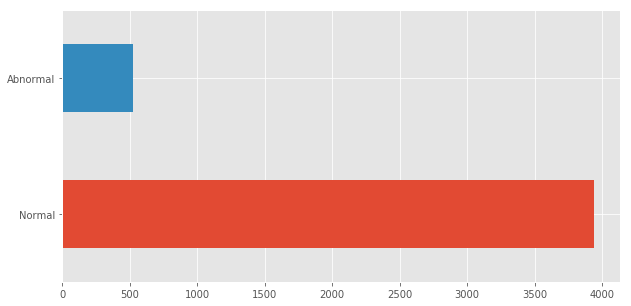

In [19]:
Lab.plot(kind='barh', figsize=(10,5), fontsize=10)

In [20]:
######################## Generate One-Hot encoding to remove categorical variables ##########################

df3 = pd.get_dummies(df2)
df3.head()

,DL Latency (ms),UL Interference,UL PRB Usage Rate(%),L.DLPwr.Avg(dBm),L.UL.RSRP.PUSCH,L.UL.RSSI.PUCCH,L.E-RAB.AbnormRel.HOFailure,L.E-RAB.AbnormRel.QCI.6,L.E-RAB.AbnormRel.QCI.9,L.E-RAB.AbnormRel.Radio.DRBReset,...,L.Paging.S1.Rx.CS,L.Paging.UU.Att,L.Paging.UU.Num,L.Paging.UU.SIUpdate,L.Paging.UU.Succ,L.Paging.UU.Succ.CSFB,Average Active User,L.UECNTX.AbnormRel,Label_Abnormal,Label_Normal
0,40.1989,-116,8.1984,41.8,17060,336,0,0,0,0,...,236,18137,17908,0,296,3,7.5092,0,0,1
1,12.9090,-117,6.8713,41.7,12222,299,0,0,0,0,...,236,18137,17908,0,209,4,5.9339,0,0,1
2,30.8297,-118,7.6623,41.7,48923,204,0,0,0,0,...,236,18137,17908,0,273,0,11.8878,0,0,1
3,26.4364,-119,9.0134,42.1,34488,37,0,0,0,0,...,62,10605,10521,0,199,1,11.1336,0,0,1
4,32.0612,-108,9.0785,42.0,27300,99255,0,0,0,0,...,62,10605,10521,0,201,1,8.6617,0,0,1


In [21]:
##########################   Conversion into X and Y #################################

X = df3.iloc[:, :22]
y = df3.iloc[:, 22:]

In [22]:
######################### Features ############################

features = list(df3.columns[:-2])
len(features)

22

In [23]:
################### Train and Test Sets #######################

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30)
#X.iloc[X_train] # return dataframe train

In [24]:
y_test.shape

(1314, 2)

In [25]:
X_train.head()

,DL Latency (ms),UL Interference,UL PRB Usage Rate(%),L.DLPwr.Avg(dBm),L.UL.RSRP.PUSCH,L.UL.RSSI.PUCCH,L.E-RAB.AbnormRel.HOFailure,L.E-RAB.AbnormRel.QCI.6,L.E-RAB.AbnormRel.QCI.9,L.E-RAB.AbnormRel.Radio.DRBReset,...,L.E-RAB.AbnormRel.TNL,L.Paging.S1.Rx,L.Paging.S1.Rx.CS,L.Paging.UU.Att,L.Paging.UU.Num,L.Paging.UU.SIUpdate,L.Paging.UU.Succ,L.Paging.UU.Succ.CSFB,Average Active User,L.UECNTX.AbnormRel
3965,88.8350,-115,13.4933,42.9,90720,495,0,0,1,1,...,0,55000,1986,55001,52947,0,807,36,23.5761,1
2008,43.1188,-115,9.8839,42.3,64838,234,0,0,1,1,...,0,27563,423,27559,27073,0,240,3,13.4881,1
808,34.4955,-116,9.2979,41.6,33790,340,0,0,1,1,...,0,55054,2073,55039,52933,0,562,21,12.3163,1
27,3.5292,-109,4.2038,41.2,481,135831,0,0,0,0,...,0,4782,18,4782,4770,0,36,0,1.2194,0
4051,50.0580,-118,4.6651,41.2,5503,228,0,0,41,0,...,41,38220,1150,38242,37269,0,272,29,5.2765,292


### Scaling/Normalization using MinMaxScaler 

In [26]:
#############    Scaling and Normalization #########################

scaler = MinMaxScaler().fit(X_train)
X_train_scaled = np.array(scaler.transform(X_train))
X_test_scaled = np.array(scaler.transform(X_test))

In [27]:
y_train_np = np.array(y_train)
y_test_np = np.array(y_test)

In [28]:
print("Training dataset shape", X_train_scaled.shape , y_train.shape)
print("Test dataset shape", X_test_scaled.shape , y_test.shape)
#print("Label encoder y shape", y_train_l.shape , y_test_l.shape)

Training dataset shape (3065, 22) (3065, 2)
Test dataset shape (1314, 22) (1314, 2)


In [29]:
X_train_scaled[0]

array([0.03321219, 0.35714286, 0.18608554, 0.37777778, 0.29074925,
       0.00262982, 0.        , 0.        , 0.00641026, 0.06666667,
       0.        , 0.        , 0.        , 0.86866634, 0.80930992,
       0.86902287, 0.87097384, 0.        , 0.6265528 , 0.41860465,
       0.55370738, 0.00100301])

######   KERAS Sequential Model ###########

In [30]:
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

In [31]:
model = Sequential()
model.add(Dense(256, input_dim = X_train_scaled.shape[1], activation = 'relu',))
model.add(Dropout (0.4))
model.add(Dense(y_train.shape[1] , activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# 'categorical_crossentropy' -- when target has multiple classes 
# 'adam' - Algo for first order gradient based optimization of stochastic objective functions 

monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=2, mode='auto')

In [32]:
model.fit(X_train_scaled,y_train, validation_data=(X_test_scaled,y_test),callbacks=[monitor],verbose=2,epochs=1000)

Train on 3065 samples, validate on 1314 samples
Epoch 1/1000
 - 1s - loss: 0.3061 - acc: 0.8959 - val_loss: 0.1893 - val_acc: 0.9277
Epoch 2/1000
 - 0s - loss: 0.1409 - acc: 0.9507 - val_loss: 0.1231 - val_acc: 0.9543
Epoch 3/1000
 - 0s - loss: 0.1016 - acc: 0.9697 - val_loss: 0.1025 - val_acc: 0.9718
Epoch 4/1000
 - 0s - loss: 0.0840 - acc: 0.9762 - val_loss: 0.0873 - val_acc: 0.9756
Epoch 5/1000
 - 0s - loss: 0.0737 - acc: 0.9817 - val_loss: 0.0787 - val_acc: 0.9772
Epoch 6/1000
 - 0s - loss: 0.0633 - acc: 0.9817 - val_loss: 0.0726 - val_acc: 0.9772
Epoch 7/1000
 - 0s - loss: 0.0593 - acc: 0.9824 - val_loss: 0.0659 - val_acc: 0.9795
Epoch 8/1000
 - 0s - loss: 0.0519 - acc: 0.9840 - val_loss: 0.0616 - val_acc: 0.9795
Epoch 9/1000
 - 0s - loss: 0.0514 - acc: 0.9840 - val_loss: 0.0577 - val_acc: 0.9817
Epoch 10/1000
 - 0s - loss: 0.0471 - acc: 0.9853 - val_loss: 0.0552 - val_acc: 0.9825
Epoch 11/1000
 - 0s - loss: 0.0438 - acc: 0.9856 - val_loss: 0.0512 - val_acc: 0.9825
Epoch 12/1000
 

## CLeaverHans FGSM Implementation  

In [33]:

wrap = KerasModelWrapper(model)
sess = backend.get_session()

In [34]:
fgsm = FastGradientMethod(wrap, sess=sess)
fgsm_params = {'eps': 0.3,
               'clip_min': 0.,
               'clip_max': 1.}

In [35]:
adv_x = fgsm.generate_np(X_train_scaled, **fgsm_params)

[INFO 2019-07-04 12:49:04,750 cleverhans] Constructing new graph for attack FastGradientMethod


In [36]:
###  Consider the attack to be constant

#adv_x = tf.stop_gradient(adv_x)

In [37]:
feats = dict()
total = 0

orig_attack = X_train_scaled - adv_x

for i in range(0, orig_attack.shape[0]):
    ind = np.where(orig_attack[i, :] != 0)[0]
    total += len(ind)
    for j in ind:
        if j in feats:
            feats[j] += 1
        else:
            feats[j] = 1

In [38]:
# The number of features that where changed for the adversarial samples
print("Number of unique features changed:", len(feats.keys()))
#print("Number of average features changed per datapoint", total/len(orig_attack))

Number of unique features changed: 22


In [39]:
pd.set_option('display.max_columns', None)  # or 1000

In [40]:
top_22 = sorted(feats , key=feats.get , reverse=True)[:22]
print("Top 22 features:", X_train.columns[top_22])

Top 22 features: Index(['L.Paging.UU.Num', 'DL Latency (ms)', 'L.E-RAB.AbnormRel.QCI.9',
       'L.Paging.UU.Succ', 'UL PRB Usage Rate(%)', 'L.UL.RSRP.PUSCH',
       'L.Paging.S1.Rx.CS', 'Average Active User', 'L.UECNTX.AbnormRel',
       'L.Paging.S1.Rx', 'L.Paging.UU.Att', 'L.UL.RSSI.PUCCH',
       'L.E-RAB.AbnormRel.TNL', 'UL Interference',
       'L.E-RAB.AbnormRel.Radio.SRBReset', 'L.E-RAB.AbnormRel.Radio.DRBReset',
       'L.E-RAB.AbnormRel.QCI.6', 'L.Paging.UU.SIUpdate', 'L.DLPwr.Avg(dBm)',
       'L.Paging.UU.Succ.CSFB', 'L.E-RAB.AbnormRel.HOFailure',
       'L.E-RAB.AbnormRel.Radio.UuNoReply'],
      dtype='object')


In [41]:
top_22_val = [100* feats[k] / y_train.shape[0] for k in top_22]

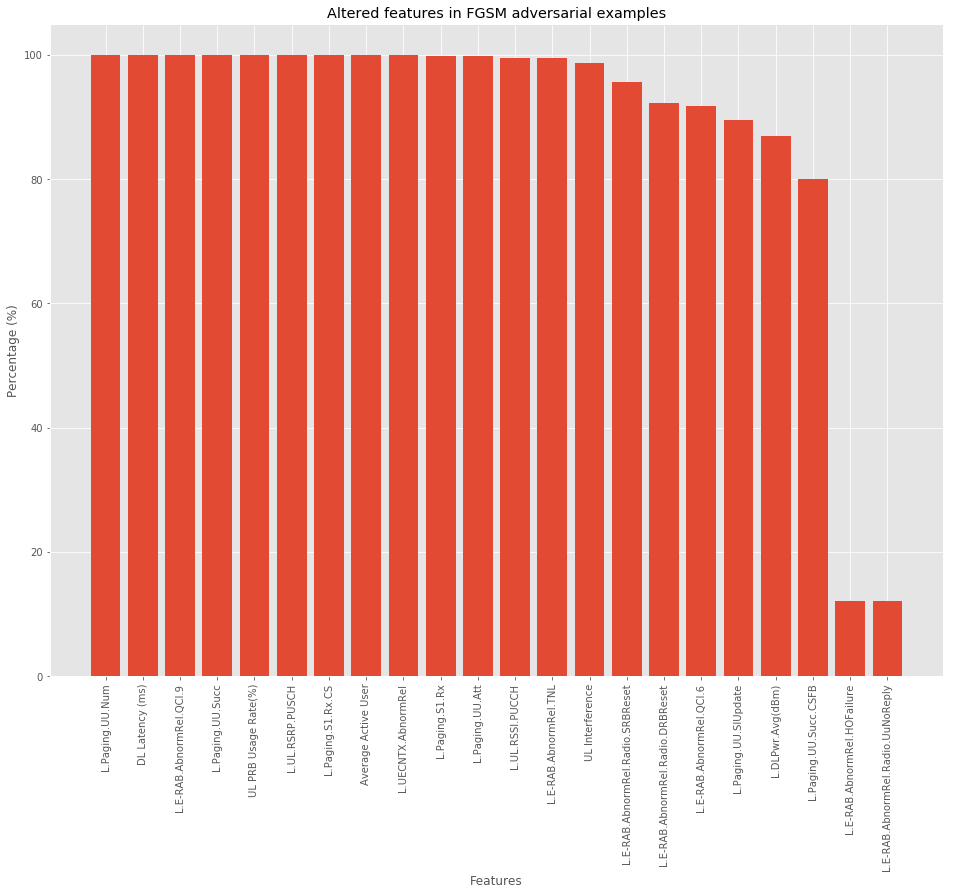

In [42]:
plt.figure(figsize=(16, 12))
plt.bar(np.arange(22), top_22_val , align='center')
plt.xticks(np.arange(22), X_train.columns[top_22], rotation='vertical')
plt.title('Altered features in FGSM adversarial examples')
plt.ylabel('Percentage (%)')
plt.xlabel('Features')
plt.savefig('Adv_features.png')

# Adversarial Re-Training 

## Adding adv_x as input isntead of X_train in new model 

In [43]:
model = Sequential()
model.add(Dense(256, input_dim = adv_x.shape[1], activation = 'relu',))
model.add(Dropout (0.4))
model.add(Dense(y_train.shape[1] , activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# 'categorical_crossentropy' -- when target has multiple classes 
# 'adam' - Algo for first order gradient based optimization of stochastic objective functions 

monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=2, mode='auto')

In [44]:
model.fit(adv_x,y_train, validation_data=(X_test_scaled,y_test),callbacks=[monitor],verbose=2,epochs=1000)

Train on 3065 samples, validate on 1314 samples
Epoch 1/1000
 - 0s - loss: 0.1510 - acc: 0.9599 - val_loss: 0.7849 - val_acc: 0.5890
Epoch 2/1000
 - 0s - loss: 0.0459 - acc: 0.9918 - val_loss: 1.1900 - val_acc: 0.2595
Epoch 3/1000
 - 0s - loss: 0.0416 - acc: 0.9922 - val_loss: 1.1480 - val_acc: 0.3029
Epoch 4/1000
 - 0s - loss: 0.0399 - acc: 0.9928 - val_loss: 1.3031 - val_acc: 0.2359
Epoch 5/1000
 - 0s - loss: 0.0367 - acc: 0.9935 - val_loss: 1.3917 - val_acc: 0.1986
Epoch 6/1000
 - 0s - loss: 0.0365 - acc: 0.9931 - val_loss: 1.4848 - val_acc: 0.1446
Epoch 00006: early stopping
